<a href="https://colab.research.google.com/github/JLongStem3/Image-Detection-ASL-USD_MS_AAI-521/blob/main/MobileNetV3_FineTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training and Fine-Tuning of MobileNetV3

In this notebook MobileNetV3 small is fine-tuned on the ASL MNIST dataset to allow for real time sign language detection

## 1: Setup and Library Installation

In [30]:
# Install necessary libraries
#!pip install kagglehub
#!pip install tensorflow

import kagglehub
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2

## 2: Dataset Preparation

First the dataset is downloaded from the Kaggle repository "Sign Language MNIST"

In [31]:
# Download the dataset from Kaggle
path = kagglehub.dataset_download("datamunge/sign-language-mnist")
print("Path to dataset files:", path)

# Load training and testing data
train_data = pd.read_csv(f"{path}/sign_mnist_train.csv")
test_data = pd.read_csv(f"{path}/sign_mnist_test.csv")

Path to dataset files: /root/.cache/kagglehub/datasets/datamunge/sign-language-mnist/versions/1


The dataset is processed into a dataframe and inputs that MobileNetV3 is designed to take (96 x 96 rgb). Note that this involves significant upscaling of the data from 24 x 24 grayscale, or almost a 50X upscaling. In the future larger images with rgb could be investigated for improvement.

In [32]:
# Define constants for data handling
BATCH_SIZE = 32
IMG_HEIGHT = 96
IMG_WIDTH = 96
NUM_CLASSES = 26

# Create tf.data.Dataset for Training and Test Data
def preprocess_image(image, label):
    # Reshape to 28x28 and add channel dimension
    image = tf.reshape(image, [28, 28, 1])
    # Resize to 96x96
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    # Convert grayscale (1 channel) to RGB (3 channels)
    image = tf.image.grayscale_to_rgb(image)
    # Normalize pixel values
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def load_dataset_from_dataframe(dataframe):
    # Extract features and labels
    labels = dataframe.iloc[:, 0].values
    images = dataframe.iloc[:, 1:].values

    # Convert labels to one-hot encoding
    labels = tf.keras.utils.to_categorical(labels, NUM_CLASSES)

    # Create TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))
    dataset = dataset.map(preprocess_image)
    dataset = dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

In [33]:
# Prepare training, validation, and test datasets
train_val_split = int(len(train_data) * 0.9)
train_df = train_data.iloc[:train_val_split]
val_df = train_data.iloc[train_val_split:]

train_dataset = load_dataset_from_dataframe(train_df)
val_dataset = load_dataset_from_dataframe(val_df)
test_dataset = load_dataset_from_dataframe(test_data)

Augment the training dataset with rotation and contrast changes

In [37]:
from tensorflow.keras import layers

# Define the data augmentation layer
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.1),       # Rotate +/- 10%
    layers.RandomBrightness(0.1)      # Change brightness
])

# Function to apply data augmentation
def augment_dataset(dataset):
    return dataset.map(lambda x, y: (data_augmentation(x, training=True), y),
                       num_parallel_calls=tf.data.AUTOTUNE)

# Apply data augmentation only to the training dataset
train_dataset = augment_dataset(train_dataset)

## 3: Grid Search for Hyperparameters

Model fine-tuning was performed over several different key hyperparameters including dropout, learning rate and hidden layer size.

In [6]:
def create_model(img_height, img_width, num_classes, dense_size=256, dropout_rate=0.5):

    # Load the base MobileNetV3 model with ImageNet weights
    base_model = MobileNetV3Small(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')

    # Define the model architecture
    inputs = Input(shape=(img_height, img_width, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(dense_size, activation='relu')(x)
    x = Dropout(dropout_rate)(x)  # Add dropout for regularization
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create and return the model
    model = Model(inputs=inputs, outputs=outputs)
    return model


In [7]:
# Base parameters

LR = 1e-5
DROPOUT = 0.3
DENSE_SIZE = 256

#### Set 1: Dropout 0.1 to 0.5

In [ ]:
dropout_val_scores = []
dropouts = [0.1, 0.3, 0.5]

In [ ]:
for d in dropouts:
    model = create_model(IMG_HEIGHT, IMG_WIDTH, NUM_CLASSES, dense_size=DENSE_SIZE, dropout_rate=d)
    model.compile(optimizer=Adam(learning_rate=LR), loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=20, verbose=0)

    # Get the last validation score
    last_val_score = history.history['val_accuracy'][-1]
    dropout_val_scores.append(last_val_score)

    print(f"Dropout: {d}, Validation Accuracy: {last_val_score}")

Dropout: 0.1, Validation Accuracy: 0.7538237571716309
Dropout: 0.3, Validation Accuracy: 0.5997815132141113
Dropout: 0.5, Validation Accuracy: 0.48215585947036743


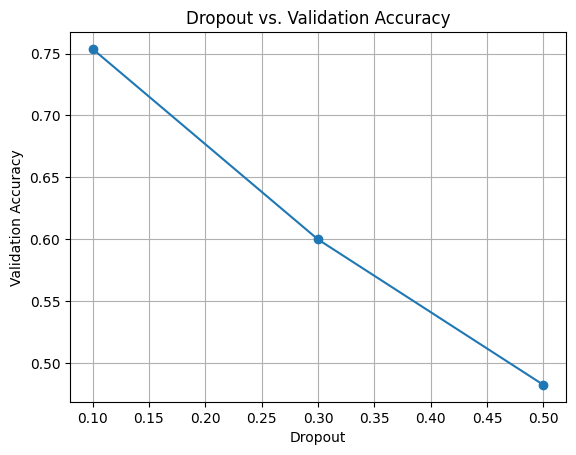

In [ ]:
# Plot dropout vs. validation score

plt.plot(dropouts, dropout_val_scores, marker='o')
plt.xlabel('Dropout')
plt.ylabel('Validation Accuracy')
plt.title('Dropout vs. Validation Accuracy')
plt.grid(True)
plt.show()

In [ ]:
DROPOUT = dropouts[np.argmax(dropout_val_scores)]
print(f"Best Dropout: {DROPOUT}")

Best Dropout: 0.1


Overall the model performance decreased with increased dropout. This is likely due to the fact that a strong dropout is prohibiting the model from developing strong patterns with specific hidden units to recognize shapes for ASL detection. As the data augmentation is already aggressive, it may be that including strong dropout combines with augmentation to prevent the model from learning at a reasonable rate.

#### Set 2: Learning Rate 1e-4 to 1e-6

In [ ]:
lr_val_scores = []
learning_rates = [1e-4, 1e-5, 1e-6]

In [ ]:
for lr in learning_rates:
    model = create_model(IMG_HEIGHT, IMG_WIDTH, NUM_CLASSES, dense_size=DENSE_SIZE, dropout_rate=DROPOUT)
    model.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=20, verbose=0)

    # Get the last validation score
    last_val_score = history.history['val_accuracy'][-1]
    lr_val_scores.append(last_val_score)

    print(f"Learning rate: {lr}, Validation Accuracy: {last_val_score}")

/usr/local/lib/python3.10/dist-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


Learning rate: 0.0001, Validation Accuracy: 0.96030592918396
Learning rate: 1e-05, Validation Accuracy: 0.7195921540260315
Learning rate: 1e-06, Validation Accuracy: 0.05863073468208313


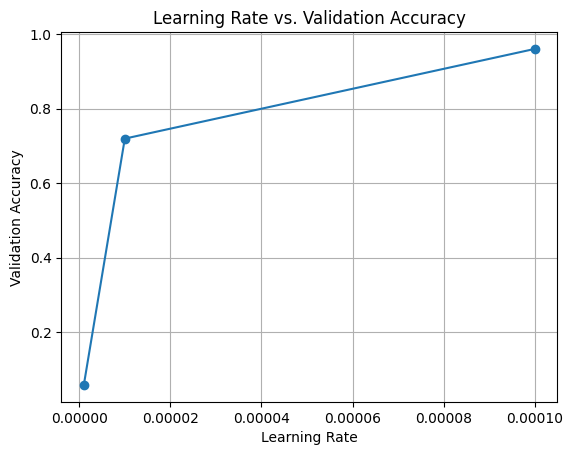

In [ ]:
# Plot learning rate vs. validation score

plt.plot(learning_rates, lr_val_scores, marker='o')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Accuracy')
plt.title('Learning Rate vs. Validation Accuracy')
plt.grid(True)
plt.show()

In [ ]:
LR = learning_rates[np.argmax(lr_val_scores)]
print(f"Best Learning Rate: {LR}")

Best Learning Rate: 0.0001


Different learning rates show that the model learns much better with higher, more aggressive learning rates. This indicates that the model needs to make significant changes to the final layer for ASL detection and that higher learning rates enable it to optimize the weights quicker. In the future it would be useful to try learning rate decay, where a high learning rate is used to start with and the learning rate gradually decreases with each training epoch.

#### Set 3: Dense Size 128 to 512

In [9]:
# Reset best values after notebook crash

LR = 0.0001
DROPOUT = 0.1

In [10]:
dense_size_val_scores = []
dense_sizes = [128, 256, 512]

In [11]:
for d in dense_sizes:
    model = create_model(IMG_HEIGHT, IMG_WIDTH, NUM_CLASSES, dense_size=d, dropout_rate=DROPOUT)
    model.compile(optimizer=Adam(learning_rate=LR), loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=20, verbose=0)

    # Get the last validation score
    last_val_score = history.history['val_accuracy'][-1]
    dense_size_val_scores.append(last_val_score)

    print(f"Dense Size: {d}, Validation Accuracy: {last_val_score}")

/usr/local/lib/python3.10/dist-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Dense Size: 128, Validation Accuracy: 0.9420976042747498
Dense Size: 256, Validation Accuracy: 0.4850691854953766
Dense Size: 512, Validation Accuracy: 0.930808424949646


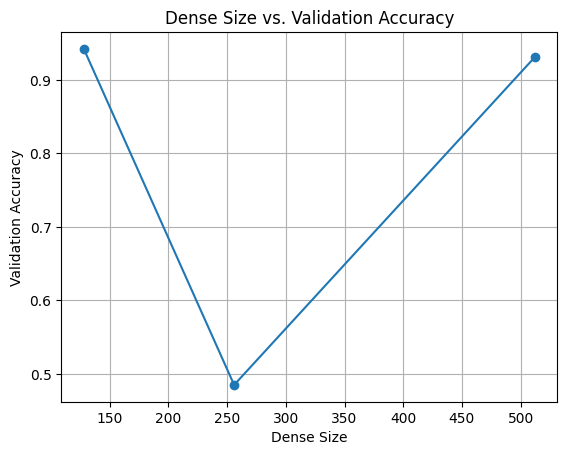

In [12]:
# Plot dense size vs. validation score

plt.plot(dense_sizes, dense_size_val_scores, marker='o')
plt.xlabel('Dense Size')
plt.ylabel('Validation Accuracy')
plt.title('Dense Size vs. Validation Accuracy')
plt.grid(True)
plt.show()

In [13]:
DENSE_SIZE = dense_sizes[np.argmax(dense_size_val_scores)]
print(f"Best Dense Size: {DENSE_SIZE}")

Best Dense Size: 128


The dense size showed an unusual pattern with hidden layer size and final validation accuracy. For hidden size of 128 and 512 the results are roughly similar, however there is a significant drop at 256. Looking at the training curves in upcoming sections this is likely just due to instability in the validation accuracy, where the model at 256 dense size happened to end with low validation accuracy.

## 4: Saving Model and Training Curves

In [39]:
# Build the best model

model = create_model(IMG_HEIGHT, IMG_WIDTH, NUM_CLASSES, dense_size=DENSE_SIZE, dropout_rate=DROPOUT)
model.compile(optimizer=Adam(learning_rate=LR), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_dataset, validation_data=val_dataset, epochs=20, verbose=0)

In [29]:
# Load the model directory from google drive

from google.colab import drive
drive.mount('/content/drive')

models_folder = "/content/drive/MyDrive"

!ls "content"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ls: cannot access 'content': No such file or directory


In [23]:
# Save the model to the models_folder

model.save(f"{models_folder}/model_03.keras")

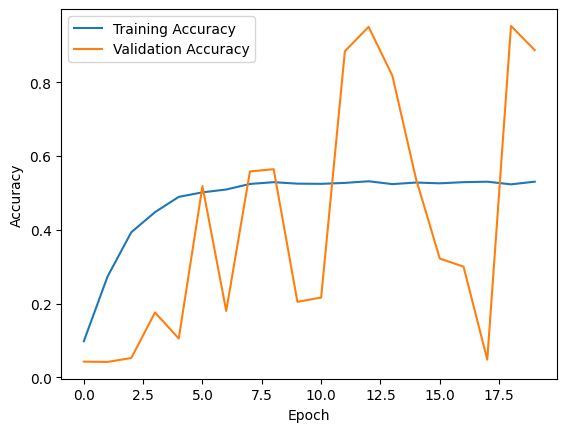

In [40]:
# Plot Training History
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [25]:
# Evaluate the Model on the Test Set
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 47.03%


Overall looking at the training and validation curves shows an interesting story. While training gradually improves it plateus around 50% accuracy. On the other hand validation is extremely unstable and goes back and forth between nearly 100% accuracy and 0% accuracy. This is likely due to excessive data augmentation, where the model is having difficulty performing well on the training data as it may be over augmented (rotated, stretched, brightness changes to where it is difficult to recognize images). However since the validation images are not augmented the model can still perform well here, even though it is unstable.

## 5: Without Data Augmentation

The model was trained without additional data augmentation to see if performance would improve. Basic parameters were chosen based on screening trials with no augmentation.

In [34]:
LR = 0.00001
DROPOUT = 0.5
DENSE_SIZE = 256

In [35]:
# Build the best model

model = create_model(IMG_HEIGHT, IMG_WIDTH, NUM_CLASSES, dense_size=DENSE_SIZE, dropout_rate=DROPOUT)
model.compile(optimizer=Adam(learning_rate=LR), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_dataset, validation_data=val_dataset, epochs=20, verbose=0)

/usr/local/lib/python3.10/dist-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


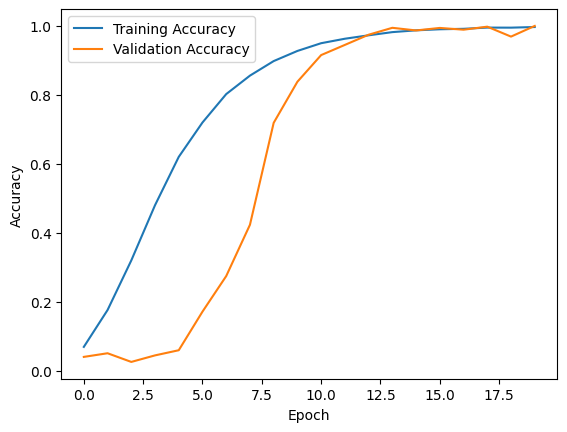

In [36]:
# Plot Training History
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The training curves improve dramatically without additional augmentation. This indicates that the model is better able to pick up patterns in the training data. In addition the validation curve is much more stable, achieving near 100% accuracy at the end of training.

Based on this result the model trained without additional data augmentation was used for evaluation and the live demo.

In [26]:
# Display Example Images and Predictions
def plot_predictions(dataset, num_images=5):
    plt.figure(figsize=(15, 5))
    for images, labels in dataset.take(1):
        preds = model.predict(images)
        for i in range(num_images):
            plt.subplot(1, num_images, i + 1)
            plt.imshow(images[i].numpy(), vmin=0, vmax=1)
            true_label = tf.argmax(labels[i])
            pred_label = tf.argmax(preds[i])
            plt.title(f"True: {true_label}, Pred: {pred_label}")
            plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


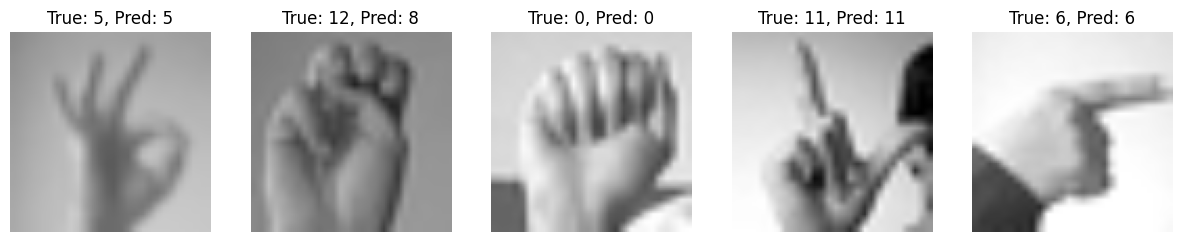

In [27]:
# Plot a few predictions
plot_predictions(test_dataset)

Some examples are shown of model predictions on the test set. Further analysis on the test set is performed in the evaluation notebook.